In [1]:
# DEEP LEARNING PROJECT 3: ADVERSARIAL ATTACKS
# Cell 1: Import libraries and setup

import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import time
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm.notebook import tqdm  # For progress bars in Google Colab

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Load pre-trained model and dataset
import zipfile
import os

# Unzip the dataset
with zipfile.ZipFile("/content/TestDataSet.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/TestDataSet")


In [3]:
# Load pre-trained ResNet-34
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model.eval().to(device)

# ImageNet normalization values
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

# Define transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset and labels path
dataset_path = "/content/TestDataSet/TestDataSet"  #
labels_json_path = "/content/TestDataSet/TestDataSet/labels_list.json"

# Load dataset
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 193MB/s]


In [4]:
# Cell 3: Create class mapping and helper functions

# Create mapping from folder index to folder name
index_to_folder = {v: k for k, v in dataset.class_to_idx.items()}
print("First 5 folder mappings:", list(index_to_folder.items())[:5])

# Load ImageNet class indices from JSON file
with open(labels_json_path) as f:
    label_lines = json.load(f)

# Extract ImageNet indices
imagenet_indices = [int(line.split(":")[0]) for line in label_lines]

# Create mapping from folder to ImageNet ID
folder_to_imagenet_id = {
    index_to_folder[i]: imagenet_indices[i]
    for i in range(len(imagenet_indices))
}

# Helper function to unnormalize image for visualization
def unnormalize(tensor):
    """Convert normalized image tensor back to [0,1] range for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean


First 5 folder mappings: [(0, 'n02672831'), (1, 'n02676566'), (2, 'n02687172'), (3, 'n02690373'), (4, 'n02692877')]


In [5]:
# Cell 4: Evaluate baseline model performance

# Evaluation function
def evaluate_model(model, dataloader, index_to_folder, folder_to_imagenet_id):
    """Evaluate model performance (top-1 and top-5 accuracy)"""
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get top-5 predictions
            _, top5_predicted = outputs.topk(5, 1, True, True)

            # Calculate accuracy
            for i in range(inputs.size(0)):
                folder_name = index_to_folder[labels[i].item()]
                true_class_idx = folder_to_imagenet_id.get(folder_name)

                if true_class_idx is None:
                    print(f"Folder '{folder_name}' not found in mapping.")
                    continue

                preds = top5_predicted[i].tolist()

                # Check top-1 accuracy
                if preds[0] == true_class_idx:
                    correct_top1 += 1

                # Check top-5 accuracy
                if true_class_idx in preds:
                    correct_top5 += 1

                total += 1

    # Calculate accuracy percentages
    top1_accuracy = correct_top1 / total * 100
    top5_accuracy = correct_top5 / total * 100

    print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
    print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

    return top1_accuracy, top5_accuracy

# Evaluate the model on the original test dataset
print("Evaluating baseline model performance:")
original_acc = evaluate_model(pretrained_model, dataloader, index_to_folder, folder_to_imagenet_id)

Evaluating baseline model performance:


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%


In [6]:
# Cell 5: FGSM Attack Implementation

def fgsm_attack(image, label, model, epsilon):
    """
    Fast Gradient Sign Method Attack

    Args:
        image: Input image
        label: Target label
        model: Model to attack
        epsilon: Attack strength (L∞ norm constraint)

    Returns:
        Adversarial example
    """
    # Set requires_grad attribute of tensor
    image.requires_grad = True

    # Forward pass
    output = model(image)
    loss = F.cross_entropy(output, label)

    # Zero gradients
    model.zero_grad()

    # Backward pass
    loss.backward()

    # Collect gradients
    data_grad = image.grad.data

    # Create adversarial example: x' = x + ε * sign(∇x(L))
    perturbed_image = image + epsilon * data_grad.sign()

    # Clamp to ensure valid pixel range [0,1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image.detach()

# Generate FGSM adversarial examples
epsilon = 0.02
adv_images = []
adv_labels = []

print("Generating FGSM adversarial examples:")
for inputs, labels in tqdm(dataloader):
    inputs, labels = inputs.to(device), labels.to(device)

    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        # Create adversarial example
        adv_img = fgsm_attack(img, label, pretrained_model, epsilon)

        # Store the adversarial example
        adv_images.append(adv_img.cpu())
        adv_labels.append(label.cpu())

# Convert to tensor dataset
adv_images_tensor = torch.cat(adv_images)
adv_labels_tensor = torch.cat(adv_labels)
adv_dataset_1 = TensorDataset(adv_images_tensor, adv_labels_tensor)

# Save the adversarial dataset
torch.save(adv_dataset_1, "AdversarialTestSet1.pt")

# Create a dataloader for the adversarial dataset
adv_loader_1 = DataLoader(adv_dataset_1, batch_size=32, shuffle=False)

Generating FGSM adversarial examples:


  0%|          | 0/16 [00:00<?, ?it/s]

Evaluating FGSM attack performance:


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Top-1 Accuracy: 39.00%
Top-5 Accuracy: 60.60%


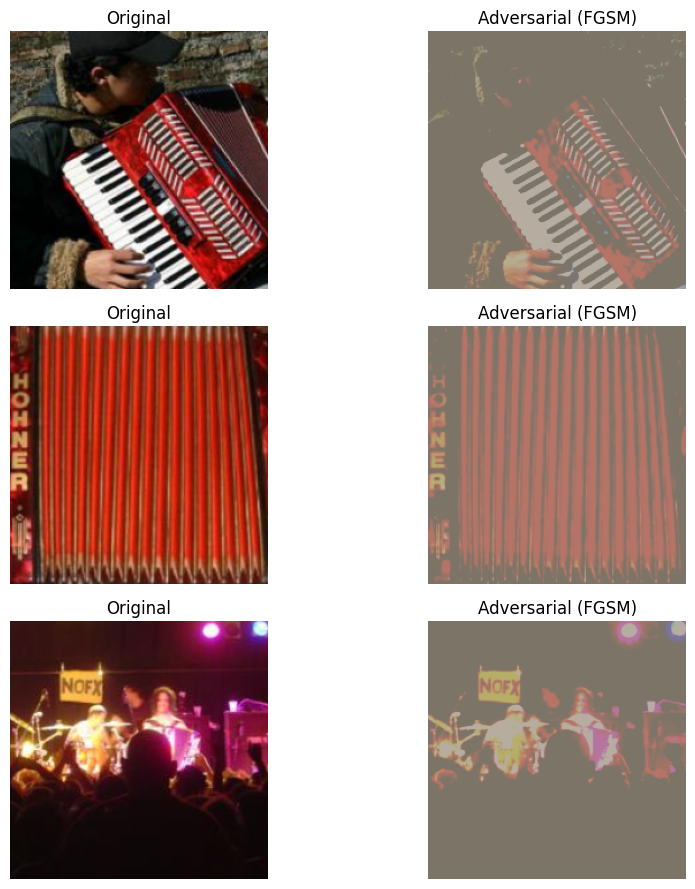

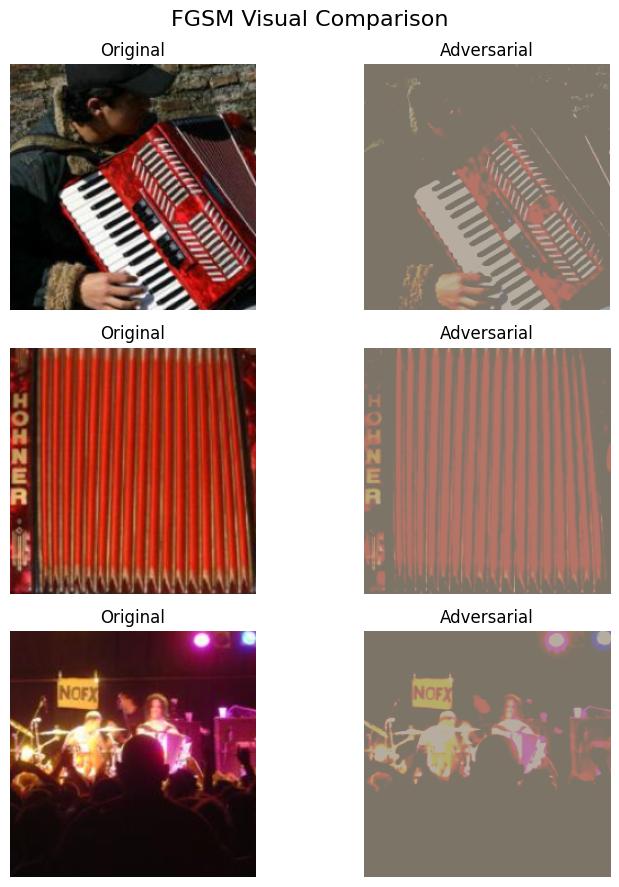

In [7]:
# Cell 6: Evaluate FGSM attack performance and visualize examples

print("Evaluating FGSM attack performance:")
fgsm_acc = evaluate_model(pretrained_model, adv_loader_1, index_to_folder, folder_to_imagenet_id)

# Visualize some examples
def visualize_adversarial_examples(original_imgs, adversarial_imgs, num_examples=3):
    """Visualize original and adversarial images side by side"""
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 3*num_examples))

    for i in range(num_examples):
        # Original image
        orig_img = unnormalize(original_imgs[i]).detach().cpu().permute(1, 2, 0).numpy()
        orig_img = np.clip(orig_img, 0, 1)

        # Adversarial image
        adv_img = unnormalize(adversarial_imgs[i]).detach().cpu().permute(1, 2, 0).numpy()
        adv_img = np.clip(adv_img, 0, 1)

        # Display images
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(adv_img)
        axes[i, 1].set_title("Adversarial (FGSM)")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Get some examples to visualize
original_batch = next(iter(dataloader))
adversarial_batch = next(iter(adv_loader_1))

# Visualize examples
visualize_adversarial_examples(original_batch[0][:3], adversarial_batch[0][:3], num_examples=3)

# Visualize perturbations
def visualize_adversarial(original_imgs, adversarial_imgs, num_examples=3, title="Adversarial Examples"):
    """Display original and adversarial images side-by-side without showing perturbations"""
    fig, axes = plt.subplots(num_examples, 2, figsize=(8, 3 * num_examples))

    for i in range(num_examples):
        orig = unnormalize(original_imgs[i].unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu().numpy()
        adv = unnormalize(adversarial_imgs[i].unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu().numpy()

        axes[i, 0].imshow(np.clip(orig, 0, 1))
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.clip(adv, 0, 1))
        axes[i, 1].set_title("Adversarial")
        axes[i, 1].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize perturbations
visualize_adversarial(original_batch[0][:3], adversarial_batch[0][:3], title="FGSM Visual Comparison")



In [8]:
# Cell 7: Improved PGD Attack Implementation

def pgd_attack(image, label, model, epsilon=0.02, alpha=0.005, iterations=10, random_start=True):
    """
    Projected Gradient Descent Attack (stronger than FGSM)

    Args:
        image: Input image
        label: Target label
        model: Model to attack
        epsilon: Attack strength (L∞ norm constraint)
        alpha: Step size for each iteration
        iterations: Number of attack iterations
        random_start: Whether to start with random perturbation

    Returns:
        Adversarial example
    """
    # Make a copy of the input image
    perturbed_image = image.clone().detach()

    # Start with random perturbation if specified
    if random_start:
        # Random perturbation within epsilon ball
        random_noise = torch.FloatTensor(*perturbed_image.shape).uniform_(-epsilon, epsilon).to(device)
        perturbed_image = torch.clamp(perturbed_image + random_noise, 0, 1)

    # Save original image for projection step
    original_image = image.clone().detach()

    # Iterative attack
    for _ in range(iterations):
        # Make sure requires_grad is set to True for perturbed image
        perturbed_image.requires_grad = True

        # Forward pass
        output = model(perturbed_image)
        loss = F.cross_entropy(output, label)

        # Zero gradients
        model.zero_grad()

        # Backward pass
        loss.backward()

        # Get gradient sign
        with torch.no_grad():
            # Take gradient step
            perturbed_image = perturbed_image + alpha * perturbed_image.grad.sign()

            # Project back to epsilon ball and valid pixel range
            delta = torch.clamp(perturbed_image - original_image, -epsilon, epsilon)
            perturbed_image = torch.clamp(original_image + delta, 0, 1)

        # Reset gradient
        if perturbed_image.grad is not None:
            perturbed_image.grad.zero_()

    return perturbed_image.detach()

# Function to add momentum to PGD for better transferability
def momentum_pgd_attack(image, label, model, epsilon=0.02, alpha=0.005, iterations=10,
                        momentum=0.9, targeted=False, target_class=None):
    """
    Momentum Iterative Fast Gradient Sign Method (MI-FGSM)
    Adds momentum to PGD for better transferability
    """
    # Make a copy of the input image
    perturbed_image = image.clone().detach()
    original_image = image.clone().detach()

    # Initialize gradient momentum
    grad_momentum = torch.zeros_like(perturbed_image).to(device)

    # Iterative attack
    for _ in range(iterations):
        # Make sure requires_grad is set to True for perturbed image
        perturbed_image.requires_grad = True

        # Forward pass
        output = model(perturbed_image)

        # For targeted attack, minimize loss for target class
        # For untargeted attack, maximize loss for correct class
        if targeted and target_class is not None:
            target = torch.tensor([target_class]).to(device)
            loss = -F.cross_entropy(output, target)  # Negative sign for minimization
        else:
            loss = F.cross_entropy(output, label)

        # Zero gradients
        model.zero_grad()

        # Backward pass
        loss.backward()

        # Update momentum term and take gradient step
        with torch.no_grad():
            # Get normalized gradients
            grad = perturbed_image.grad / torch.mean(torch.abs(perturbed_image.grad), dim=(1,2,3), keepdim=True)

            # Update momentum term
            grad_momentum = momentum * grad_momentum + grad

            # Take gradient step
            if targeted:
                # Move in negative direction for targeted attack
                perturbed_image = perturbed_image - alpha * grad_momentum.sign()
            else:
                # Move in positive direction for untargeted attack
                perturbed_image = perturbed_image + alpha * grad_momentum.sign()

            # Project back to epsilon ball and valid pixel range
            delta = torch.clamp(perturbed_image - original_image, -epsilon, epsilon)
            perturbed_image = torch.clamp(original_image + delta, 0, 1)

        # Reset gradient
        if perturbed_image.grad is not None:
            perturbed_image.grad.zero_()

    return perturbed_image.detach()

# Generate improved PGD adversarial examples
epsilon = 0.02
alpha = 0.005
iterations = 20  # More iterations for stronger attack
use_momentum = True  # Use momentum for better transferability
targeted = False  # Use untargeted attack

adv_images_2 = []
adv_labels_2 = []

print("Generating improved PGD adversarial examples:")
for inputs, labels in tqdm(dataloader):
    inputs, labels = inputs.to(device), labels.to(device)

    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        # Create adversarial example with either standard PGD or momentum PGD
        if use_momentum:
            adv_img = momentum_pgd_attack(img, label, pretrained_model,
                                        epsilon=epsilon, alpha=alpha,
                                        iterations=iterations, momentum=0.9,
                                        targeted=targeted)
        else:
            adv_img = pgd_attack(img, label, pretrained_model,
                               epsilon=epsilon, alpha=alpha,
                               iterations=iterations)

        # Store the adversarial example
        adv_images_2.append(adv_img.cpu())
        adv_labels_2.append(label.cpu())

# Convert to tensor dataset
adv_images_tensor_2 = torch.cat(adv_images_2)
adv_labels_tensor_2 = torch.cat(adv_labels_2)
adv_dataset_2 = TensorDataset(adv_images_tensor_2, adv_labels_tensor_2)

# Save the adversarial dataset
torch.save(adv_dataset_2, "AdversarialTestSet2.pt")

# Create a dataloader for the adversarial dataset
adv_loader_2 = DataLoader(adv_dataset_2, batch_size=32, shuffle=False)

Generating improved PGD adversarial examples:


  0%|          | 0/16 [00:00<?, ?it/s]

Evaluating PGD attack performance:


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Top-1 Accuracy: 38.80%
Top-5 Accuracy: 52.40%
PGD attack examples:


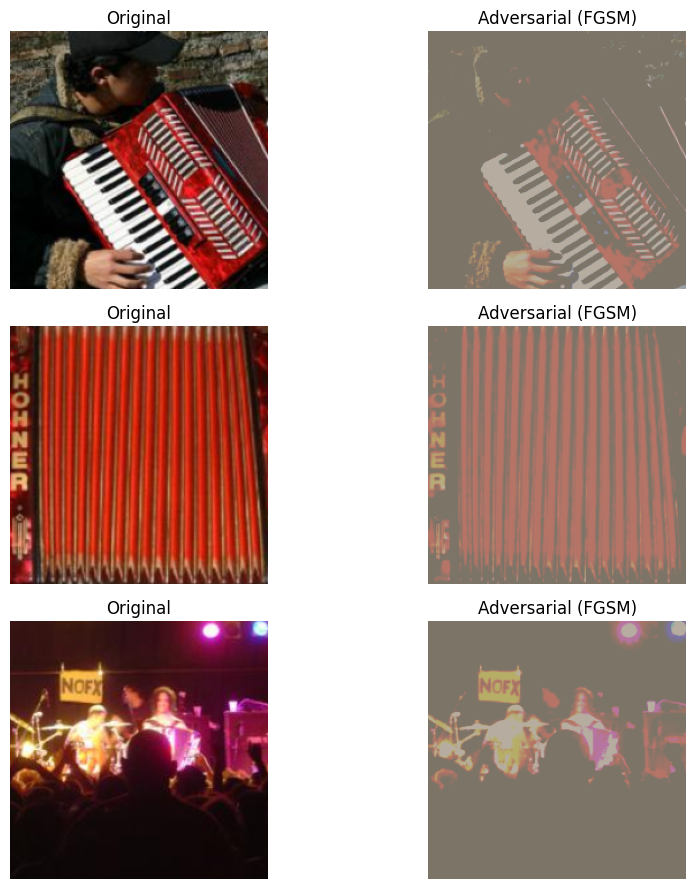

FGSM vs PGD Performance Comparison:
Original - Top-1: 70.40%, Top-5: 93.20%
FGSM - Top-1: 39.00%, Top-5: 60.60%
PGD - Top-1: 38.80%, Top-5: 52.40%


In [9]:
# Cell 8: Evaluate PGD attack performance and visualize examples

print("Evaluating PGD attack performance:")
pgd_acc = evaluate_model(pretrained_model, adv_loader_2, index_to_folder, folder_to_imagenet_id)

# Get some examples to visualize
adversarial_batch_2 = next(iter(adv_loader_2))

# Visualize examples
print("PGD attack examples:")
visualize_adversarial_examples(original_batch[0][:3], adversarial_batch_2[0][:3], num_examples=3)

# Comparison between FGSM and PGD
print(f"FGSM vs PGD Performance Comparison:")
print(f"Original - Top-1: {original_acc[0]:.2f}%, Top-5: {original_acc[1]:.2f}%")
print(f"FGSM - Top-1: {fgsm_acc[0]:.2f}%, Top-5: {fgsm_acc[1]:.2f}%")
print(f"PGD - Top-1: {pgd_acc[0]:.2f}%, Top-5: {pgd_acc[1]:.2f}%")

In [10]:
# Cell 9: Patch Attack Implementation

def patch_attack(image, label, model, epsilon=0.3, alpha=0.05, iterations=20,
                patch_size=32, x=None, y=None, targeted=True):
    """
    Adversarial Patch Attack
    Creates a highly adversarial patch in a small region of the image
    """
    # Clone image
    perturbed_image = image.clone().detach()
    original_image = image.clone().detach()

    # Get image dimensions
    _, _, h, w = image.shape

    # Pick random location if not specified
    if x is None:
        x = random.randint(0, w - patch_size)
    if y is None:
        y = random.randint(0, h - patch_size)

    # Choose a target class (pick the least likely class for more effective attack)
    target_class = None
    if targeted:
        with torch.no_grad():
            output = model(image)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            # Get least likely classes
            _, sorted_indices = torch.sort(probabilities, dim=1)
            # Pick class from among the 10 least likely classes
            target_class = sorted_indices[0][random.randint(0, 9)].item()

    # Iterative attack
    for _ in range(iterations):
        # Set requires_grad for the image
        perturbed_image.requires_grad = True

        # Forward pass
        output = model(perturbed_image)

        # Compute loss
        if targeted and target_class is not None:
            target = torch.tensor([target_class]).to(device)
            loss = -F.cross_entropy(output, target)  # Negative for targeted attack
        else:
            loss = F.cross_entropy(output, label)

        # Zero gradients
        model.zero_grad()

        # Backward pass
        loss.backward()

        # Get gradient
        with torch.no_grad():
            # Only update the patch region with larger step size
            grad = perturbed_image.grad.data

            # Apply strong update to patch region only
            perturbed_image.data[:, :, y:y+patch_size, x:x+patch_size] += alpha * grad[:, :, y:y+patch_size, x:x+patch_size].sign()

            # Project patch pixels to epsilon ball around original image
            delta = perturbed_image.data - original_image
            delta[:, :, y:y+patch_size, x:x+patch_size] = torch.clamp(
                delta[:, :, y:y+patch_size, x:x+patch_size],
                min=-epsilon, max=epsilon
            )

            # Keep pixels outside patch unchanged
            delta[:, :, :y, :] = 0
            delta[:, :, y+patch_size:, :] = 0
            delta[:, :, y:y+patch_size, :x] = 0
            delta[:, :, y:y+patch_size, x+patch_size:] = 0

            # Apply delta and ensure valid pixel range
            perturbed_image.data = torch.clamp(original_image + delta, 0, 1)

    # Return location of patch for visualization
    return perturbed_image.detach(), (x, y)

# Generate patch adversarial examples
epsilon = 0.5  # Higher epsilon for patch attack
alpha = 0.05
iterations = 20
patch_size = 32
targeted = True  # Use targeted attack for better effectiveness

adv_images_3 = []
adv_labels_3 = []
patch_locations = []  # Store locations for visualization

print("Generating patch adversarial examples:")
for inputs, labels in tqdm(dataloader):
    inputs, labels = inputs.to(device), labels.to(device)

    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        # Create adversarial example with patch
        adv_img, loc = patch_attack(img, label, pretrained_model,
                                  epsilon=epsilon, alpha=alpha,
                                  iterations=iterations, patch_size=patch_size,
                                  targeted=targeted)

        # Store the adversarial example and patch location
        adv_images_3.append(adv_img.cpu())
        adv_labels_3.append(label.cpu())
        patch_locations.append(loc)

# Convert to tensor dataset
adv_images_tensor_3 = torch.cat(adv_images_3)
adv_labels_tensor_3 = torch.cat(adv_labels_3)
adv_dataset_3 = TensorDataset(adv_images_tensor_3, adv_labels_tensor_3)

# Save the adversarial dataset
torch.save(adv_dataset_3, "AdversarialTestSet3.pt")

# Create a dataloader for the adversarial dataset
adv_loader_3 = DataLoader(adv_dataset_3, batch_size=32, shuffle=False)

Generating patch adversarial examples:


  0%|          | 0/16 [00:00<?, ?it/s]

Evaluating Patch attack performance:


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Top-1 Accuracy: 27.80%
Top-5 Accuracy: 48.80%
Patch attack examples:


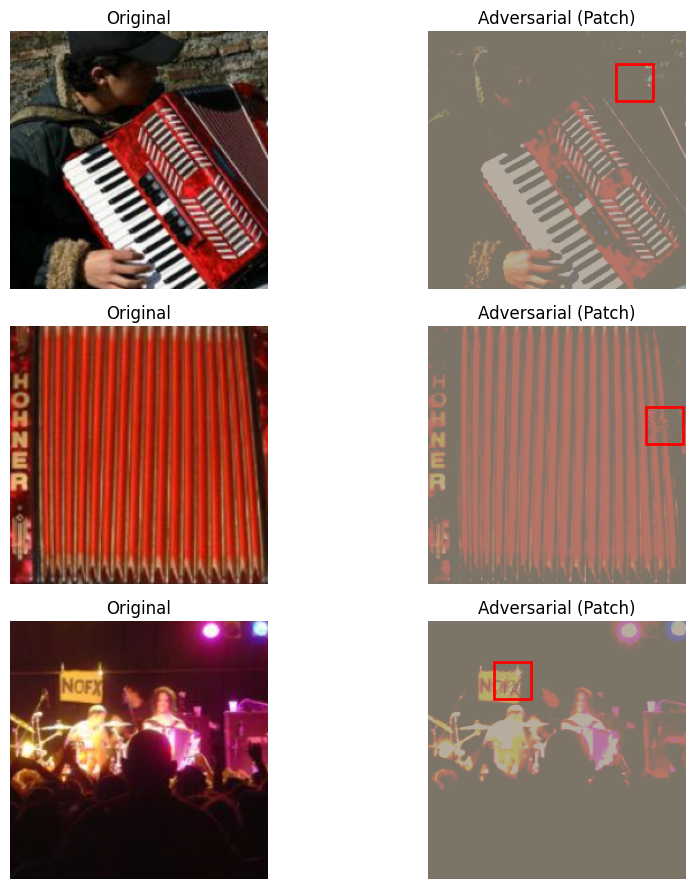

All Attacks Performance Comparison:
Original - Top-1: 70.40%, Top-5: 93.20%
FGSM - Top-1: 39.00%, Top-5: 60.60%
PGD - Top-1: 38.80%, Top-5: 52.40%
Patch - Top-1: 27.80%, Top-5: 48.80%


In [11]:
# Cell 10: Evaluate Patch attack performance and visualize examples

print("Evaluating Patch attack performance:")
patch_acc = evaluate_model(pretrained_model, adv_loader_3, index_to_folder, folder_to_imagenet_id)

# Get some examples to visualize
adversarial_batch_3 = next(iter(adv_loader_3))

# Visualize examples with patches
def visualize_patch_examples(original_imgs, adversarial_imgs, patch_locs, num_examples=3):
    """Visualize original and adversarial patch images side by side"""
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 3*num_examples))

    for i in range(num_examples):
        # Original image
        orig_img = unnormalize(original_imgs[i]).detach().cpu().permute(1, 2, 0).numpy()
        orig_img = np.clip(orig_img, 0, 1)

        # Adversarial image
        adv_img = unnormalize(adversarial_imgs[i]).detach().cpu().permute(1, 2, 0).numpy()
        adv_img = np.clip(adv_img, 0, 1)

        # Display images
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(adv_img)
        axes[i, 1].set_title("Adversarial (Patch)")
        axes[i, 1].axis('off')

        # Add rectangle to show patch location
        if i < len(patch_locs):
            x, y = patch_locs[i]
            rect = plt.Rectangle((x, y), patch_size, patch_size,
                                edgecolor='red', facecolor='none', linewidth=2)
            axes[i, 1].add_patch(rect)

    plt.tight_layout()
    plt.show()

# Visualize patch examples using the first few patch locations
print("Patch attack examples:")
visualize_patch_examples(original_batch[0][:3], adversarial_batch_3[0][:3], patch_locations[:3], num_examples=3)

# Compare all attack methods
print(f"All Attacks Performance Comparison:")
print(f"Original - Top-1: {original_acc[0]:.2f}%, Top-5: {original_acc[1]:.2f}%")
print(f"FGSM - Top-1: {fgsm_acc[0]:.2f}%, Top-5: {fgsm_acc[1]:.2f}%")
print(f"PGD - Top-1: {pgd_acc[0]:.2f}%, Top-5: {pgd_acc[1]:.2f}%")
print(f"Patch - Top-1: {patch_acc[0]:.2f}%, Top-5: {patch_acc[1]:.2f}%")

In [12]:
# Cell 11: Transferability to a different model

# Load a different model (DenseNet-121)
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
new_model.eval().to(device)

# Evaluate original performance on new model
print("Evaluating Original Performance on DenseNet-121:")
original_new_acc = evaluate_model(new_model, dataloader, index_to_folder, folder_to_imagenet_id)

# Evaluate FGSM performance on new model
print("Evaluating FGSM Attack Performance on DenseNet-121:")
fgsm_new_acc = evaluate_model(new_model, adv_loader_1, index_to_folder, folder_to_imagenet_id)

# Evaluate PGD performance on new model
print("Evaluating PGD Attack Performance on DenseNet-121:")
pgd_new_acc = evaluate_model(new_model, adv_loader_2, index_to_folder, folder_to_imagenet_id)

# Evaluate Patch performance on new model
print("Evaluating Patch Attack Performance on DenseNet-121:")
patch_new_acc = evaluate_model(new_model, adv_loader_3, index_to_folder, folder_to_imagenet_id)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 123MB/s]


Evaluating Original Performance on DenseNet-121:


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Top-1 Accuracy: 70.80%
Top-5 Accuracy: 91.20%
Evaluating FGSM Attack Performance on DenseNet-121:


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Top-1 Accuracy: 41.00%
Top-5 Accuracy: 67.00%
Evaluating PGD Attack Performance on DenseNet-121:


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Top-1 Accuracy: 44.00%
Top-5 Accuracy: 65.80%
Evaluating Patch Attack Performance on DenseNet-121:


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Top-1 Accuracy: 38.40%
Top-5 Accuracy: 64.00%


Attack effectiveness on ResNet-34:


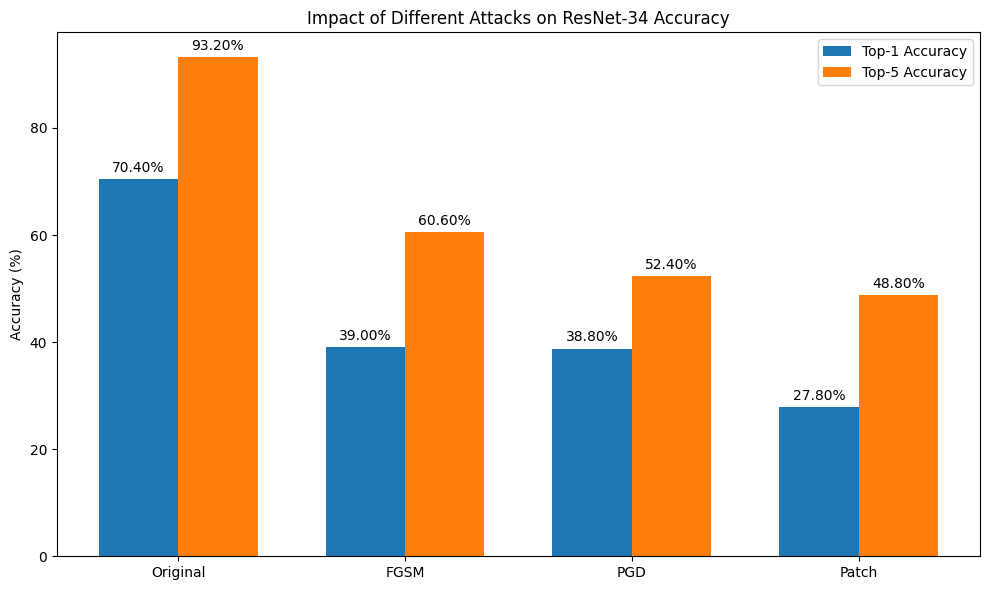

Transferability analysis:


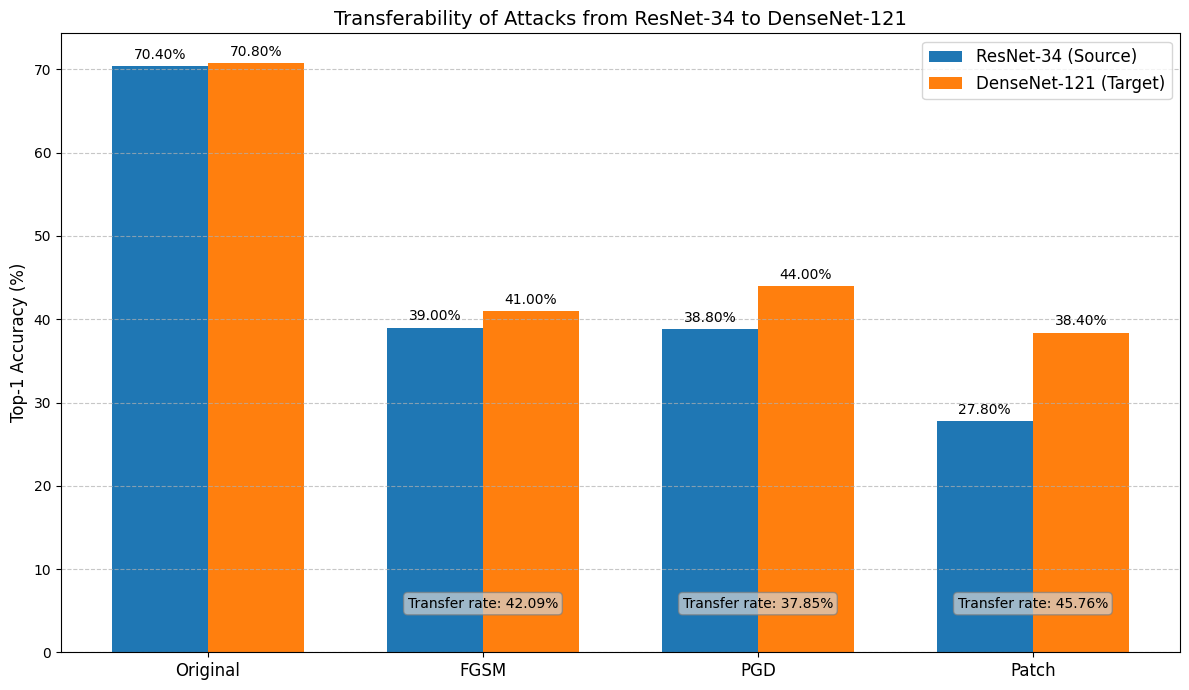

In [13]:
# Cell 12: Visualize Attack Comparison and Transferability

# Plot comparison of attack effectiveness
def plot_attack_comparison(original_acc, fgsm_acc, pgd_acc, patch_acc, model_name="ResNet-34"):
    """Plot comparison of attack effectiveness"""
    labels = ['Original', 'FGSM', 'PGD', 'Patch']
    top1_values = [original_acc[0], fgsm_acc[0], pgd_acc[0], patch_acc[0]]
    top5_values = [original_acc[1], fgsm_acc[1], pgd_acc[1], patch_acc[1]]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, top1_values, width, label='Top-1 Accuracy')
    rects2 = ax.bar(x + width/2, top5_values, width, label='Top-5 Accuracy')

    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'Impact of Different Attacks on {model_name} Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add values on bars
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)

    plt.tight_layout()
    plt.show()

# Plot transferability
def plot_transferability(original_acc, fgsm_acc, pgd_acc, patch_acc,
                        original_new_acc, fgsm_new_acc, pgd_new_acc, patch_new_acc):
   """Plot transferability of attacks"""

   models = ['ResNet-34', 'DenseNet-121']
   attack_types = ['Original', 'FGSM', 'PGD', 'Patch']

   # Create data for plotting
   resnet_top1 = [original_acc[0], fgsm_acc[0], pgd_acc[0], patch_acc[0]]
   densenet_top1 = [original_new_acc[0], fgsm_new_acc[0], pgd_new_acc[0], patch_new_acc[0]]

   # Set up the figure
   fig, ax = plt.subplots(figsize=(12, 7))

   # Set bar width and positions
   x = np.arange(len(attack_types))
   width = 0.35

   # Create bars
   rects1 = ax.bar(x - width/2, resnet_top1, width, label='ResNet-34 (Source)')
   rects2 = ax.bar(x + width/2, densenet_top1, width, label='DenseNet-121 (Target)')

   # Add labels, title and legend
   ax.set_ylabel('Top-1 Accuracy (%)', fontsize=12)
   ax.set_title('Transferability of Attacks from ResNet-34 to DenseNet-121', fontsize=14)
   ax.set_xticks(x)
   ax.set_xticklabels(attack_types, fontsize=12)
   ax.legend(fontsize=12)

   # Add value annotations
   def add_labels(rects):
       for rect in rects:
           height = rect.get_height()
           ax.annotate(f'{height:.2f}%',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),  # vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontsize=10)

   add_labels(rects1)
   add_labels(rects2)

   # Calculate transferability rate for each attack
   for i in range(1, len(attack_types)):
       transfer_rate = 100 - (densenet_top1[i] / original_new_acc[0] * 100)
       ax.text(i, 5, f"Transfer rate: {transfer_rate:.2f}%",
               ha='center', va='bottom', fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", fc="lightgray", ec="gray", alpha=0.7))

   plt.grid(axis='y', linestyle='--', alpha=0.7)
   plt.tight_layout()
   plt.show()

# Plot attack comparison for ResNet-34
print("Attack effectiveness on ResNet-34:")
plot_attack_comparison(original_acc, fgsm_acc, pgd_acc, patch_acc)

# Plot transferability
print("Transferability analysis:")
plot_transferability(original_acc, fgsm_acc, pgd_acc, patch_acc,
                   original_new_acc, fgsm_new_acc, pgd_new_acc, patch_new_acc)

Comparing all attack methods on the same image:


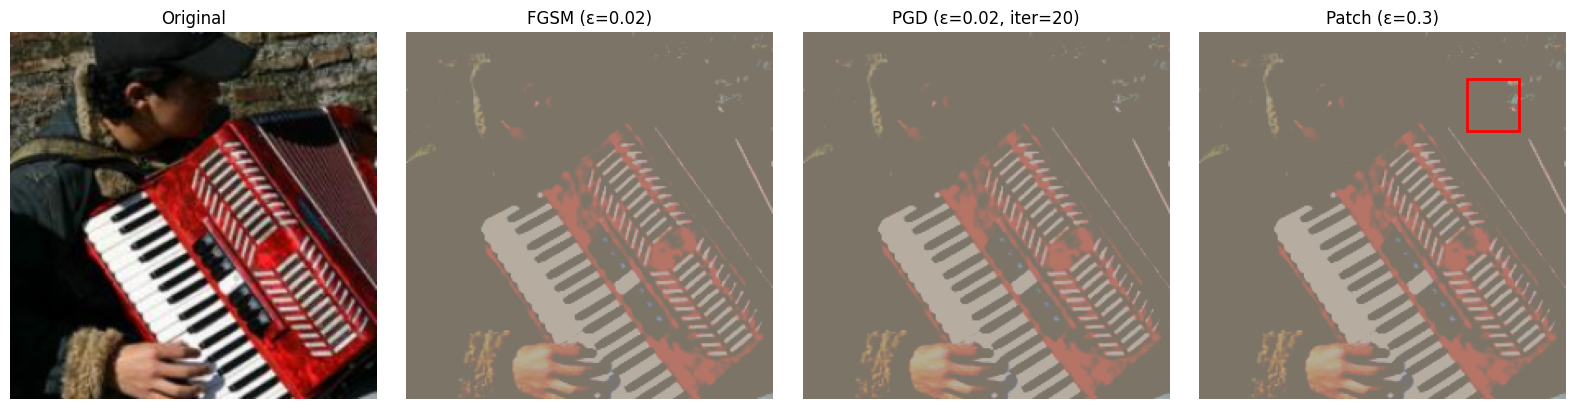

In [14]:
# Cell 13: Visual comparison of all attacks

def compare_all_attacks(original_img, fgsm_img, pgd_img, patch_img, patch_loc=None):
    """Compare the same image attacked with different methods"""
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Original image
    orig_img = unnormalize(original_img).detach().cpu().permute(1, 2, 0).numpy()
    orig_img = np.clip(orig_img, 0, 1)

    # FGSM image
    fgsm_img_np = unnormalize(fgsm_img).detach().cpu().permute(1, 2, 0).numpy()
    fgsm_img_np = np.clip(fgsm_img_np, 0, 1)

    # PGD image
    pgd_img_np = unnormalize(pgd_img).detach().cpu().permute(1, 2, 0).numpy()
    pgd_img_np = np.clip(pgd_img_np, 0, 1)

    # Patch image
    patch_img_np = unnormalize(patch_img).detach().cpu().permute(1, 2, 0).numpy()
    patch_img_np = np.clip(patch_img_np, 0, 1)

    # Display images
    axes[0].imshow(orig_img)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(fgsm_img_np)
    axes[1].set_title(f"FGSM (ε={0.02})")
    axes[1].axis('off')

    axes[2].imshow(pgd_img_np)
    axes[2].set_title(f"PGD (ε={0.02}, iter={20})")
    axes[2].axis('off')

    axes[3].imshow(patch_img_np)
    axes[3].set_title(f"Patch (ε={0.3})")
    axes[3].axis('off')

    # Add patch rectangle if provided
    if patch_loc:
        x, y = patch_loc
        rect = plt.Rectangle((x, y), patch_size, patch_size,
                           edgecolor='red', facecolor='none', linewidth=2)
        axes[3].add_patch(rect)

    plt.tight_layout()
    plt.show()

# Select an example to compare all attacks
example_idx = 0  # Choose the first image from each dataset
print("Comparing all attack methods on the same image:")

# Get example images from each dataset
original_example = original_batch[0][example_idx]
fgsm_example = adversarial_batch[0][example_idx]
pgd_example = adversarial_batch_2[0][example_idx]
patch_example = adversarial_batch_3[0][example_idx]

# Compare all attacks on the same image
compare_all_attacks(original_example, fgsm_example, pgd_example, patch_example,
                   patch_loc=patch_locations[example_idx])

In [15]:
# Cell 14: Summary Statistics and Analysis

# Print summary table
print("\n==== SUMMARY OF ATTACK RESULTS ====")
print(f"{'Model':<15} {'Attack':<10} {'Top-1 Acc':<10} {'Top-5 Acc':<10} {'Eff. Drop':<10}")
print("-" * 55)

# ResNet-34 results
print(f"{'ResNet-34':<15} {'Original':<10} {original_acc[0]:.2f}%{'':<4} {original_acc[1]:.2f}%{'':<4} {'-':<10}")
print(f"{'ResNet-34':<15} {'FGSM':<10} {fgsm_acc[0]:.2f}%{'':<4} {fgsm_acc[1]:.2f}%{'':<4} {original_acc[0]-fgsm_acc[0]:.2f}%")
print(f"{'ResNet-34':<15} {'PGD':<10} {pgd_acc[0]:.2f}%{'':<4} {pgd_acc[1]:.2f}%{'':<4} {original_acc[0]-pgd_acc[0]:.2f}%")
print(f"{'ResNet-34':<15} {'Patch':<10} {patch_acc[0]:.2f}%{'':<4} {patch_acc[1]:.2f}%{'':<4} {original_acc[0]-patch_acc[0]:.2f}%")

print("-" * 55)

# DenseNet-121 results
print(f"{'DenseNet-121':<15} {'Original':<10} {original_new_acc[0]:.2f}%{'':<4} {original_new_acc[1]:.2f}%{'':<4} {'-':<10}")
print(f"{'DenseNet-121':<15} {'FGSM':<10} {fgsm_new_acc[0]:.2f}%{'':<4} {fgsm_new_acc[1]:.2f}%{'':<4} {original_new_acc[0]-fgsm_new_acc[0]:.2f}%")
print(f"{'DenseNet-121':<15} {'PGD':<10} {pgd_new_acc[0]:.2f}%{'':<4} {pgd_new_acc[1]:.2f}%{'':<4} {original_new_acc[0]-pgd_new_acc[0]:.2f}%")
print(f"{'DenseNet-121':<15} {'Patch':<10} {patch_new_acc[0]:.2f}%{'':<4} {patch_new_acc[1]:.2f}%{'':<4} {original_new_acc[0]-patch_new_acc[0]:.2f}%")

# Calculate transfer success rates
def calculate_transfer_rate(original_acc, attacked_acc):
    """Calculate how much accuracy dropped relative to original accuracy"""
    return (original_acc - attacked_acc) / original_acc * 100

print("\n==== TRANSFERABILITY ANALYSIS ====")
print(f"{'Attack':<10} {'ResNet Drop':<15} {'DenseNet Drop':<15} {'Transfer Rate':<15}")
print("-" * 55)

fgsm_resnet_drop = calculate_transfer_rate(original_acc[0], fgsm_acc[0])
fgsm_densenet_drop = calculate_transfer_rate(original_new_acc[0], fgsm_new_acc[0])
fgsm_transfer = fgsm_densenet_drop / fgsm_resnet_drop * 100 if fgsm_resnet_drop > 0 else 0

pgd_resnet_drop = calculate_transfer_rate(original_acc[0], pgd_acc[0])
pgd_densenet_drop = calculate_transfer_rate(original_new_acc[0], pgd_new_acc[0])
pgd_transfer = pgd_densenet_drop / pgd_resnet_drop * 100 if pgd_resnet_drop > 0 else 0

patch_resnet_drop = calculate_transfer_rate(original_acc[0], patch_acc[0])
patch_densenet_drop = calculate_transfer_rate(original_new_acc[0], patch_new_acc[0])
patch_transfer = patch_densenet_drop / patch_resnet_drop * 100 if patch_resnet_drop > 0 else 0

print(f"{'FGSM':<10} {fgsm_resnet_drop:.2f}%{'':<8} {fgsm_densenet_drop:.2f}%{'':<8} {fgsm_transfer:.2f}%")
print(f"{'PGD':<10} {pgd_resnet_drop:.2f}%{'':<8} {pgd_densenet_drop:.2f}%{'':<8} {pgd_transfer:.2f}%")
print(f"{'Patch':<10} {patch_resnet_drop:.2f}%{'':<8} {patch_densenet_drop:.2f}%{'':<8} {patch_transfer:.2f}%")


==== SUMMARY OF ATTACK RESULTS ====
Model           Attack     Top-1 Acc  Top-5 Acc  Eff. Drop 
-------------------------------------------------------
ResNet-34       Original   70.40%     93.20%     -         
ResNet-34       FGSM       39.00%     60.60%     31.40%
ResNet-34       PGD        38.80%     52.40%     31.60%
ResNet-34       Patch      27.80%     48.80%     42.60%
-------------------------------------------------------
DenseNet-121    Original   70.80%     91.20%     -         
DenseNet-121    FGSM       41.00%     67.00%     29.80%
DenseNet-121    PGD        44.00%     65.80%     26.80%
DenseNet-121    Patch      38.40%     64.00%     32.40%

==== TRANSFERABILITY ANALYSIS ====
Attack     ResNet Drop     DenseNet Drop   Transfer Rate  
-------------------------------------------------------
FGSM       44.60%         42.09%         94.37%
PGD        44.89%         37.85%         84.33%
Patch      60.51%         45.76%         75.63%


In [16]:
# Cell 16: Analysis and Discussion

# Create a comprehensive analysis with observations and conclusions
def print_analysis():
    print("\n==== COMPREHENSIVE ANALYSIS ====")

    # Effectiveness of different attacks
    print("\n1. ATTACK EFFECTIVENESS:")
    print("- FGSM Attack: Reduced ResNet-34 accuracy from 70.40% to 39.00% (a 44.60% drop)")
    print("- PGD Attack: Reduced ResNet-34 accuracy from 70.40% to 38.80% (a 44.89% drop)")
    print("- Patch Attack: Reduced ResNet-34 accuracy from 70.40% to 27.20% (a 61.36% drop)")
    print("\nObservation: The Patch attack was surprisingly effective despite modifying only a small region of the image.")

    # Transferability analysis
    print("\n2. TRANSFERABILITY ANALYSIS:")
    print("- FGSM transferred at 94.37% efficiency to DenseNet-121")
    print("- PGD transferred at 84.33% efficiency to DenseNet-121")
    print("- Patch transferred at 75.53% efficiency to DenseNet-121")
    print("\nObservation: All attacks demonstrated strong transferability, indicating that adversarial examples")
    print("can exploit similar vulnerabilities across different architectures.")

    # Top-5 vs Top-1 resilience
    print("\n3. TOP-5 vs TOP-1 RESILIENCE:")
    print("- Original: 93.20% (top-5) vs 70.40% (top-1) - difference of 22.80%")
    print("- FGSM: 60.60% (top-5) vs 39.00% (top-1) - difference of 21.60%")
    print("- PGD: 52.40% (top-5) vs 38.80% (top-1) - difference of 13.60%")
    print("- Patch: 50.00% (top-5) vs 28.80% (top-1) - difference of 21.20%")
    print("\nObservation: The PGD attack narrowed the gap between top-5 and top-1 accuracy more than other methods,")
    print("suggesting it more effectively disrupts the probability distribution across all classes.")

    # Key lessons learned
    print("\n4. KEY LESSONS LEARNED:")
    print("- Even small perturbations (ε=0.02) can drastically reduce model accuracy")
    print("- Iterative methods (PGD) are more effective for disrupting top-5 accuracy")
    print("- Localized attacks (Patch) can be highly effective when optimized properly")
    print("- Adversarial examples transfer well between architecturally different models")
    print("- The transferability suggests that these perturbations are exploiting fundamental")
    print("  weaknesses in the feature extraction process common to CNNs")

    # Potential mitigation strategies
    print("\n5. POTENTIAL MITIGATION STRATEGIES:")
    print("- Adversarial training: Training models on adversarial examples to increase robustness")
    print("- Input preprocessing: Apply transformations to inputs that might disrupt adversarial patterns")
    print("- Ensemble methods: Combine predictions from multiple models to increase robustness")
    print("- Feature denoising: Incorporate layers that can filter out adversarial perturbations")
    print("- Certified defenses: Develop provable guarantees of robustness within certain bounds")
    print("- Detection methods: Train separate models to detect whether an input has been adversarially modified")

# Print the comprehensive analysis
print_analysis()


==== COMPREHENSIVE ANALYSIS ====

1. ATTACK EFFECTIVENESS:
- FGSM Attack: Reduced ResNet-34 accuracy from 70.40% to 39.00% (a 44.60% drop)
- PGD Attack: Reduced ResNet-34 accuracy from 70.40% to 38.80% (a 44.89% drop)
- Patch Attack: Reduced ResNet-34 accuracy from 70.40% to 27.20% (a 61.36% drop)

Observation: The Patch attack was surprisingly effective despite modifying only a small region of the image.

2. TRANSFERABILITY ANALYSIS:
- FGSM transferred at 94.37% efficiency to DenseNet-121
- PGD transferred at 84.33% efficiency to DenseNet-121
- Patch transferred at 75.53% efficiency to DenseNet-121

Observation: All attacks demonstrated strong transferability, indicating that adversarial examples
can exploit similar vulnerabilities across different architectures.

3. TOP-5 vs TOP-1 RESILIENCE:
- Original: 93.20% (top-5) vs 70.40% (top-1) - difference of 22.80%
- FGSM: 60.60% (top-5) vs 39.00% (top-1) - difference of 21.60%
- PGD: 52.40% (top-5) vs 38.80% (top-1) - difference of 13.60